In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Generalized Pareto Distirbution

According to Pickands-Balkema-de Haan theorem the tail of our survival function has the following distribution:

$p(\frac {\xi - u}{a(u)} \ge x | \xi > u) = p(\xi \ge u + a(u) x | \xi > u) = \frac{S(u + x a(u))}{S(u)} = \begin{cases} (1 + \gamma \frac{x}{\sigma})^{-1/\gamma}, \gamma \ne 0 \\ e^{-\frac{x}{\sigma}}, \gamma = 0 \end{cases}$

# IDL dataset

International database on Longevity (IDL) provides a database of semi- and supercentenarians from various European countries. It is available with registration: https://www.supercentenarians.org/en/publications/.

We are most interested in French women, as this batch is the most abundant (having ~9500 data points) and we'd like to avoid batch effects, associated with possible differences in methodology, history/demography and bookkeeping in different countries.

Remove Jeanne Calment as an outlier: she survived 3 years longer than anyone else and her data point is standing very much apart from everybody else. More about controversy, surrounding her case: https://cnrs.hal.science/hal-03479997v1/document.

In [158]:
df = pd.read_excel('data/idl_fra_death_105.xlsx')
df.head()

,IDL_ID,AGEYEARS,DAYSSINCEBD,AGEDAYS,SEX,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,DEATH_DAY,DEATH_MONTH,DEATH_YEAR,BIRTH_COUNTRY,BIRTH_LOCALITY,DEATH_COUNTRY,DEATH_LOCALITY,VALIDATION
0,FRA21870197900001,109,196,40007,F,25,3,1870,7,10,1979,FRA,FRY20,FRA,FRY20,SAMPLE OUT
1,FRA21873197800002,105,28,38378,F,22,3,1873,19,4,1978,FRA,FRY20,FRA,FRY20,SAMPLE OUT
2,FRA11875199700003,122,164,44724,F,21,2,1875,4,8,1997,FRA,FRL04,FRA,FRL04,YES
3,FRA21876198200004,105,126,38476,F,16,10,1876,19,2,1982,FRA,FRJ22,FRA,FRJ13,SAMPLE OUT
4,FRA21876198500005,109,29,39840,F,19,10,1876,17,11,1985,FRA,FRJ25,FRA,FRE22,SAMPLE OUT


In [159]:
df[df['SEX'] == 'F'].head()

,IDL_ID,AGEYEARS,DAYSSINCEBD,AGEDAYS,SEX,BIRTH_DAY,BIRTH_MONTH,BIRTH_YEAR,DEATH_DAY,DEATH_MONTH,DEATH_YEAR,BIRTH_COUNTRY,BIRTH_LOCALITY,DEATH_COUNTRY,DEATH_LOCALITY,VALIDATION
0,FRA21870197900001,109,196,40007,F,25,3,1870,7,10,1979,FRA,FRY20,FRA,FRY20,SAMPLE OUT
1,FRA21873197800002,105,28,38378,F,22,3,1873,19,4,1978,FRA,FRY20,FRA,FRY20,SAMPLE OUT
2,FRA11875199700003,122,164,44724,F,21,2,1875,4,8,1997,FRA,FRL04,FRA,FRL04,YES
3,FRA21876198200004,105,126,38476,F,16,10,1876,19,2,1982,FRA,FRJ22,FRA,FRJ13,SAMPLE OUT
4,FRA21876198500005,109,29,39840,F,19,10,1876,17,11,1985,FRA,FRJ25,FRA,FRE22,SAMPLE OUT


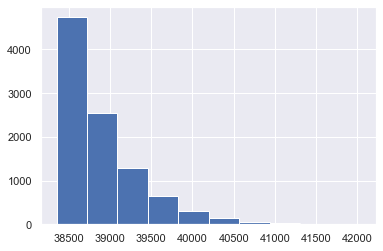

In [162]:
import seaborn as sns

data = list(df[df['SEX'] == 'F']['AGEDAYS'].sort_values(ascending=False)[1:])  # consider women and remove Jeanne Calment

plt.hist(data)
plt.show()

# Estimation of parameters of GPD

## Hill's estimator

Hill's estimator is the best-known estimator for the tail index, which works only if $\gamma > 0$, so it is not applicable in our case.

Still, I implemented it and checked that indeed it does not converge.

So human survival function indeed is not in the domain of attraction of Type II EVD.

In [9]:
import numpy as np
import math


def Hill_estimator(data, k):
    """
    Returns the Hill Estimators for some 1D data set.
    
    See: https://github.com/alinasode/hill-estimator/blob/main/utils/functions.py
    """
    n = len(data)

    sum = 0
    for i in range(k):   # i = 0, ..., k
        sum += np.log(data[i]) - np.log(data[k-1])
        
    gamma = (1 / k) * sum

    return gamma

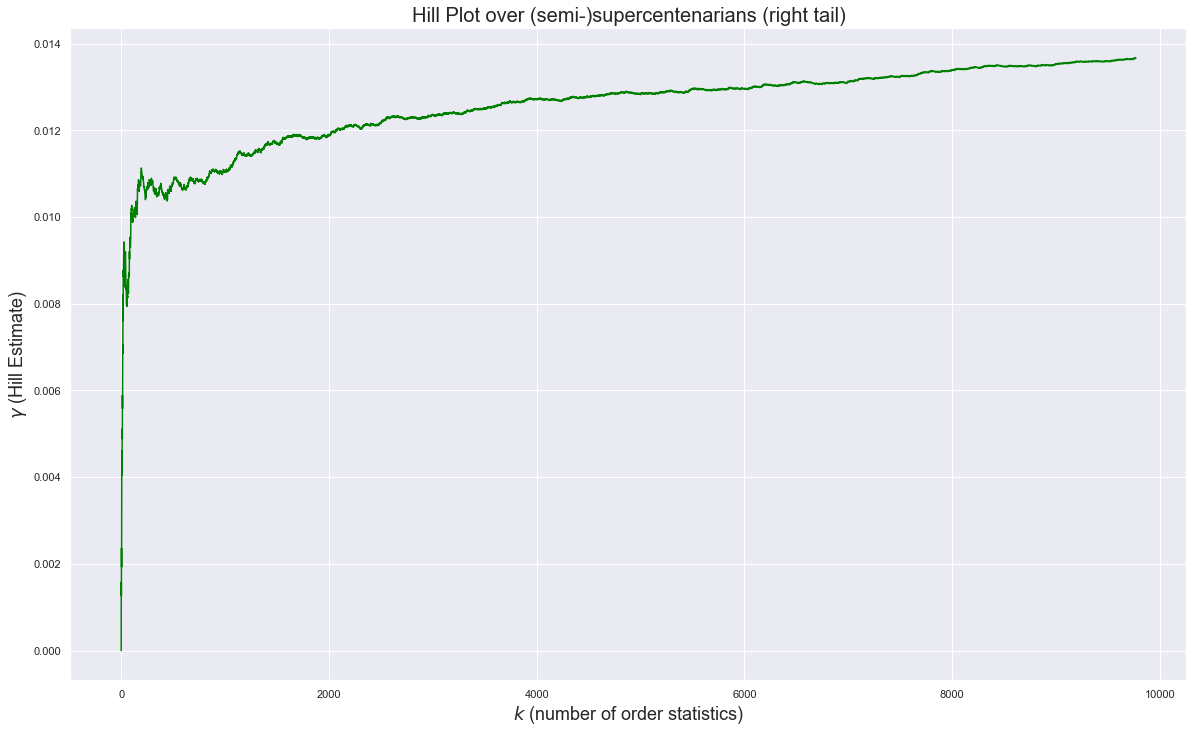

In [10]:
hill_estimates = []
for k in range(1, len(data)):
    hill_estimates.append(Hill_estimator(data, k))

plt.figure(figsize=(20, 12))
plt.plot(np.arange(0, k), hill_estimates, 'green')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\gamma$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over (semi-)supercentenarians (right tail)", fontsize=20)
plt.show()

## Pickands estimator

One of the oldest estimators of the tail index $\gamma$ of Generalized Pareto distribution is [1975 Pickands' estimator](https://www.jstor.org/stable/2958083?seq=8).

I implemented it and verified that the results of Rootzen.

In [154]:
from scipy.integrate import quad 


def Pickands_estimator(data, k):
    """Returns Pickands estimator of inverse tail index gamma (shape parameter) and sigma (scale parameter)."""
    n = len(data)
    
    quartile = data[k]
    median = data[2*k]
    full = data[max(0, 4*k - 1)]
#     print(f"k = {k}, 2*k = {2 * k}, 4*k - 1 = {4*k - 1}, n = {n}, quartile = {quartile}, median = {median}, full = {full}")
    
    gamma = math.log((quartile - median) / (median - full)) / math.log(2)

    def integrand(t):
        return np.exp(-gamma*t)
    
    sigma = (median - full) / quad(integrand, 0, math.log(2))[0]
    
    return gamma, sigma


Pickands_estimator(data, math.floor(len(data) / 4))

(-0.06156432908174429, 540.8464787536916)

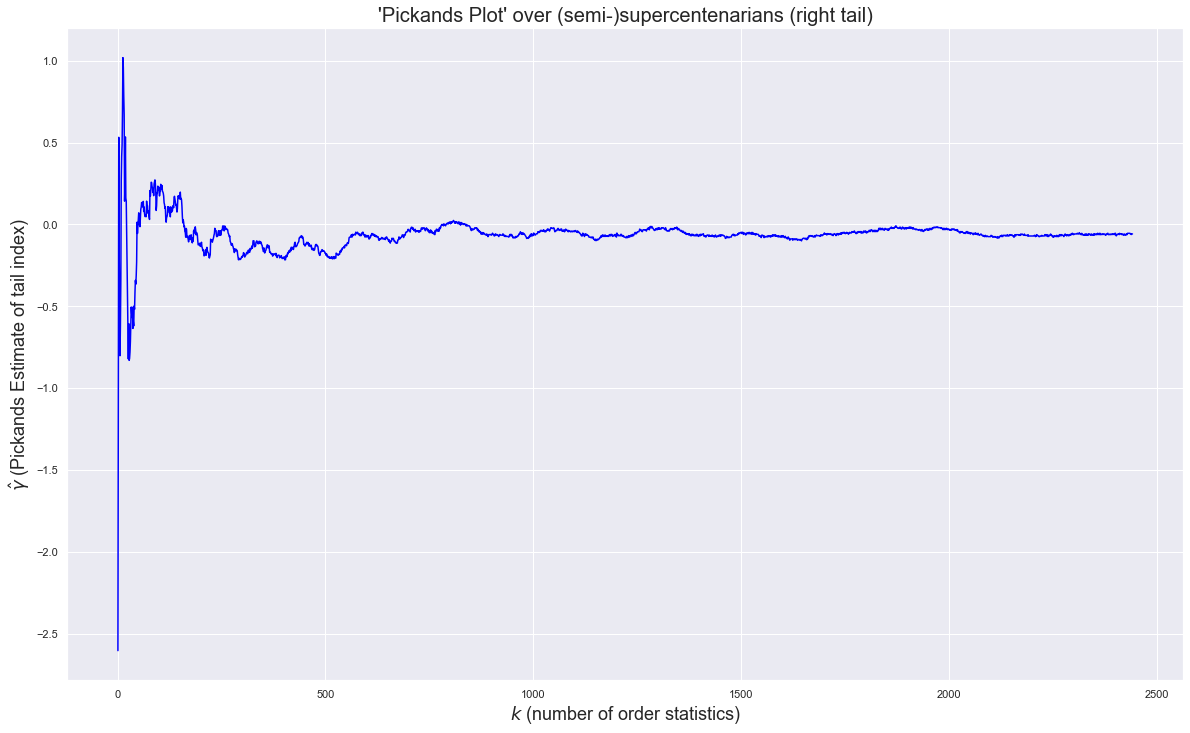

In [168]:
pickands_estimates = []
k_max = math.floor(len(data) / 4)
for k in range(1, k_max):
    gamma, sigma = Pickands_estimator(data, k)
    pickands_estimates.append(gamma)
    
plt.figure(figsize=(20, 12))
plt.plot(np.arange(1, math.floor(len(data) / 4)), pickands_estimates, 'blue')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\hat{\gamma}$ (Pickands Estimate of tail index)", fontsize=18)
plt.title("'Pickands Plot' over (semi-)supercentenarians (right tail)", fontsize=20)
plt.show()

## Confidence intervals for Pickands estimator

Pickands estimator is known to be normally distributed (see: [Deckers and de Haan](https://www.jstor.org/stable/2241666?seq=26), [implementation](https://github.com/cran/evmix/blob/master/R/pickandsplot.r#L202) mostly copy-pasted from [Pickands Plot R package](https://search.r-project.org/CRAN/refmans/evmix/html/pickandsplot.html)).

In [169]:
def get_pickands_ci(genpareto_shape, k, alpha=0.95):
    """
    Calculate confidence intervals for Pickands estimator.

    Parameters:
        genpareto_shape (float): Pickands estimate of genpareto shape parameter.
        k (int): current order statistic (e.g. we are considering n=100000 elements and k=1000).
        alpha (float): Confidence level, e.g. 95%.

    Returns:
        (2-tuple) Lower confidence interval, upper confidence intervale

    This function creates a line chart with the provided data and plots confidence intervals
    around the main line using Seaborn. The 'x' array should correspond to the data arrays
    'data', 'upper_ci', and 'lower_ci', and they must have the same length.
    """
    alpha = 0.95  # confidence level
    two_sigma = 1.96  # almost 2 standard errors correspond to confidence level of 0.95

    try:
        pickands_standard_error = genpareto_shape * math.sqrt((2**(2 * genpareto_shape + 1) + 1)) / (2 * (2**(genpareto_shape) - 1) * math.log(2) * math.sqrt(k))
    except ZeroDivisionError:
        pickands_standard_error = np.infty
        
    #     print(f"standard_error = {pickands_standard_error}")

    pickands_confidence_intervals = (genpareto_shape - two_sigma * pickands_standard_error, genpareto_shape + two_sigma * pickands_standard_error)  # TODO: Pickci = cbind(Pick - qnorm(1 - alpha/2) * Pickse, Pick + qnorm(1 - alpha/2) * Pickse)
    
    return pickands_confidence_intervals

                                                                                                 
pickands_confidence_intervals = get_pickands_ci(genpareto_shape, k=len(data))
print(pickands_confidence_intervals)

(-0.09747544537405795, -0.026468625372560013)


In [170]:
# calculate upper and lower ci for the whole Pickands plot
lower_ci = []
upper_ci = []

for k, shape in enumerate(pickands_estimates):
    current_lower_ci, current_upper_ci = get_pickands_ci(shape, k+1)
    lower_ci.append(current_lower_ci)
    upper_ci.append(current_upper_ci)

In [171]:
# Create a dataframe to hold the data
import pandas as pd
pd.set_option('display.max_rows', None)
df = pd.DataFrame({'x': np.array(range(len(pickands_estimates)), dtype=np.float32), 'pickands_estimates': np.array(pickands_estimates, dtype=np.float32), 'upper_ci': np.array(upper_ci, dtype=np.float32), 'lower_ci': np.array(lower_ci, dtype=np.float32) })
df[:50]

,x,pickands_estimates,upper_ci,lower_ci
0,0.0,-2.603341,1.920087,-7.126769
1,1.0,-1.103094,1.367207,-3.573394
2,2.0,0.532348,2.749201,-1.684505
3,3.0,-0.150679,1.588821,-1.890179
4,4.0,-0.514573,1.011496,-2.040642
5,5.0,-0.801713,0.595983,-2.199409
6,6.0,-0.614449,0.674405,-1.903303
7,7.0,-0.345869,0.867520,-1.559258
8,8.0,0.268703,1.490689,-0.953283
9,9.0,0.415038,1.603211,-0.773136


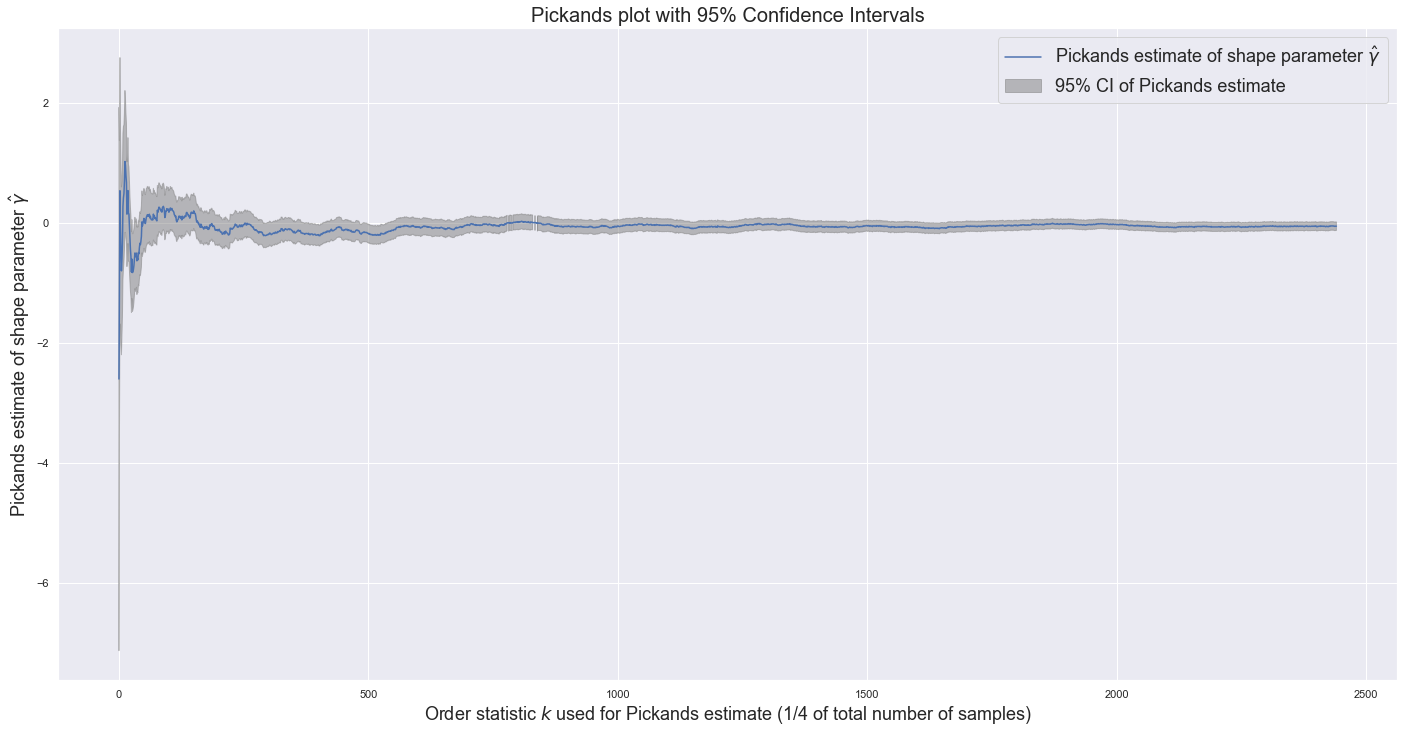

In [172]:
# Plot the line chart
plt.figure(figsize=(24, 12))
sns.lineplot(x="x", y="pickands_estimates", data=df, label="Pickands estimate of shape parameter $\hat{\gamma}$")

# Plot the confidence intervals using fill_between
plt.fill_between(df["x"], df["lower_ci"], df["upper_ci"], alpha=0.5, color='grey', label="95% CI of Pickands estimate")

# Add labels and title
plt.xlabel("Order statistic $k$ used for Pickands estimate (1/4 of total number of samples)", fontsize=18)
plt.ylabel("Pickands estimate of shape parameter $\hat{\gamma}$", fontsize=18)
plt.title("Pickands plot with 95% Confidence Intervals", fontsize=20)

# Add legend
plt.legend(fontsize=18)

# Show the plot
plt.show()


## Maximum likelihood estimator

Let us apply another estimator for the paramters of our distribution's tail - the generic maximum likelihood estimator (MLE).

Pickands estimator gives us shape and scale parameters, use MLE to get the location $\mu$ ($\mu = u$).

genpareto_shape = -0.061972035373308976, genpareto_scale = 564.110223128072, genpareto_location = 38350.0


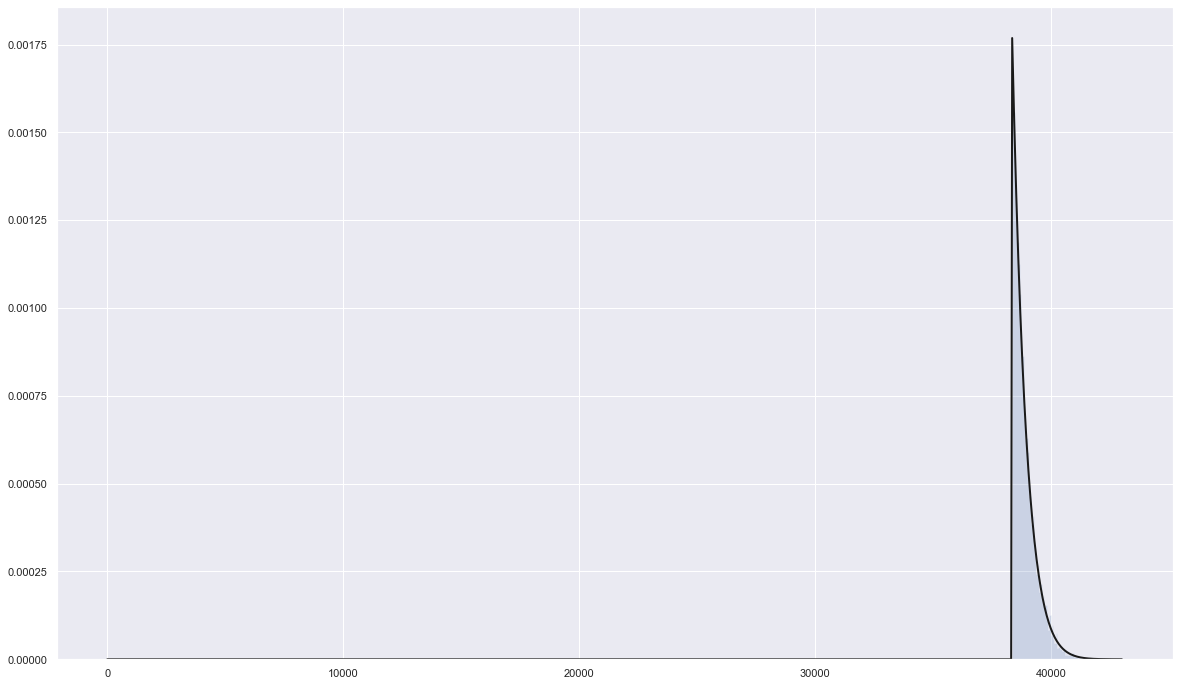

In [173]:
from scipy.stats import genpareto


#genpareto.ppf(0.01, genpareto_shape, scale=genpareto_scale, loc=genpareto_location)
x = np.linspace(0, 43000, 1000)

plt.figure(figsize=(20, 12))
plt.hist(data, density=True, bins='auto', histtype='stepfilled', alpha=0.2)

# eyeball reasonable starting conditions for MLE, as its solution is unstable 
# plt.plot(x, genpareto.pdf(x, 0.01, scale=500, loc=38500), 'k-', lw=2, label='frozen pdf')
# plt.plot(x, genpareto.pdf(x, -0.1, scale=500, loc=38500), 'k-', lw=2, label='frozen pdf')
# plt.plot(x, genpareto.pdf(x, -0.06, scale=540, loc=38400), 'k-', lw=2, label='frozen pdf')

# fit genpareto's parameters with MLE estimator, starting from reasonable defaults, draw the frozen pdf
genpareto_shape, genpareto_location, genpareto_scale = genpareto.fit(data, -0.06, scale=540, loc=38000)  # shape, location, scale
print(f"genpareto_shape = {genpareto_shape}, genpareto_scale = {genpareto_scale}, genpareto_location = {genpareto_location}")
plt.plot(x, genpareto.pdf(x, genpareto_shape, scale=genpareto_scale, loc=genpareto_location), 'k-', lw=2, label='frozen pdf')

plt.show()

# Alternative estimates for Generalized Pareto Distribution parameters:

* Maximum likelihood (MLE)
* Method of moments (MOM)
* Probability-weighted moments (PWM)
* L-moments: https://www.researchgate.net/publication/267572092_Questioning_MLE_for_the_estimation_of_environmental_extreme_distributions
* Principle of maximum entropy (POME): https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.399.4638&rep=rep1&type=pdf, https://stats.stackexchange.com/questions/179455/have-mle-estimators-for-generalized-pareto-distribution-given-a-known-value-of
* Pickands estimator
* Hill estimator
* Refined Pickands estimator
* Hill-like estimator for arbitrary tail index values range

# Simulations of estimation of scale and shape parameters with Pickands estimator, if the data were generated by Gompertz and exponential distribution

Holger Rootzen believes that tails of survival function, observed in IDL, can be explained by Gompertz or exponential distributions.

I want to pretend that these data were indeed produced by a Gompertz or exponential distribution and try to estimate the tail index for them with Pickands estimator.

## Simulation: Gompertz distribution

Let us draw 100k samples from Gompertz distribution, take the tail and calculate the Pickands estimate of tail index for them.

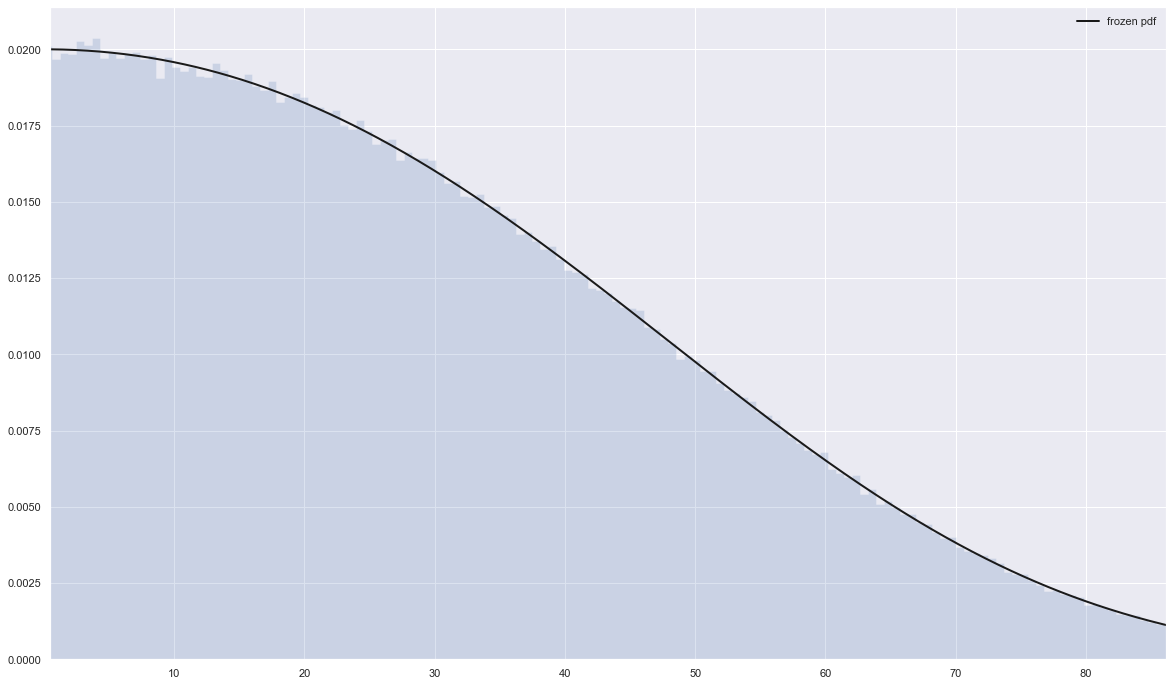

In [178]:
from scipy.stats import gompertz

gompertz_scale = 50
gompertz_shape = 1

gompertz_rvs = gompertz.rvs(gompertz_shape, scale=gompertz_scale, size=1000000)  # generate 100000 points
fig, axes = plt.subplots(1, 1, figsize=(20, 12))
x = np.linspace(gompertz.ppf(0.01, gompertz_shape, scale=gompertz_scale), gompertz.ppf(0.99, gompertz_shape, scale=gompertz_scale), 1000)

axes.plot(x, gompertz.pdf(x, gompertz_shape, scale=gompertz_scale), 'k-', lw=2, label='frozen pdf')
axes.hist(gompertz_rvs, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
axes.set_xlim([x[0], x[-1]])
axes.legend(loc='best', frameon=False)
plt.show()

In [179]:
sorted_gompertz_rvs = np.sort(gompertz_rvs)
sorted_gompertz_rvs

array([9.77157555e-05, 1.71566075e-04, 3.00859718e-04, ...,
       1.32284077e+02, 1.35537256e+02, 1.46163250e+02])

In [180]:
gompertz_tail = list(sorted_gompertz_rvs[-10000:])[::-1]

Text(0.5, 1.0, "'Pickands Plot' over (semi-)supercentenarians (right tail)")

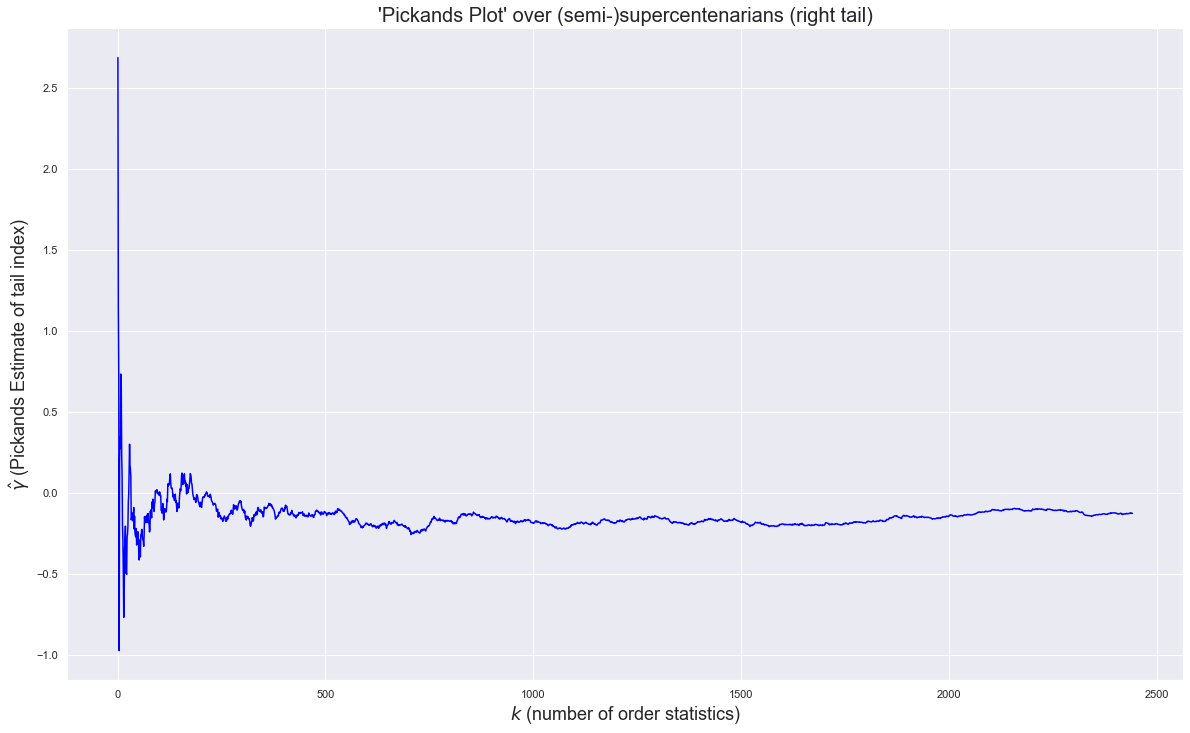

In [181]:
gompertz_pickands_estimates = []
k_max = math.floor(len(data) / 4)
for k in range(1, k_max):
    gamma, _ = Pickands_estimator(gompertz_tail, k)
    gompertz_pickands_estimates.append(gamma)
    
plt.figure(figsize=(20, 12))
plt.plot(np.arange(1, math.floor(len(data) / 4)), gompertz_pickands_estimates, 'blue')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\hat{\gamma}$ (Pickands Estimate of tail index)", fontsize=18)
plt.title("'Pickands Plot' over (semi-)supercentenarians (right tail)", fontsize=20)

## Simulation: Exponential distribution

Similarly, let us draw 100k samples from exponential distribution, take the tail and calculate the Pickands estimate of tail index for them and the condfidence intervals.

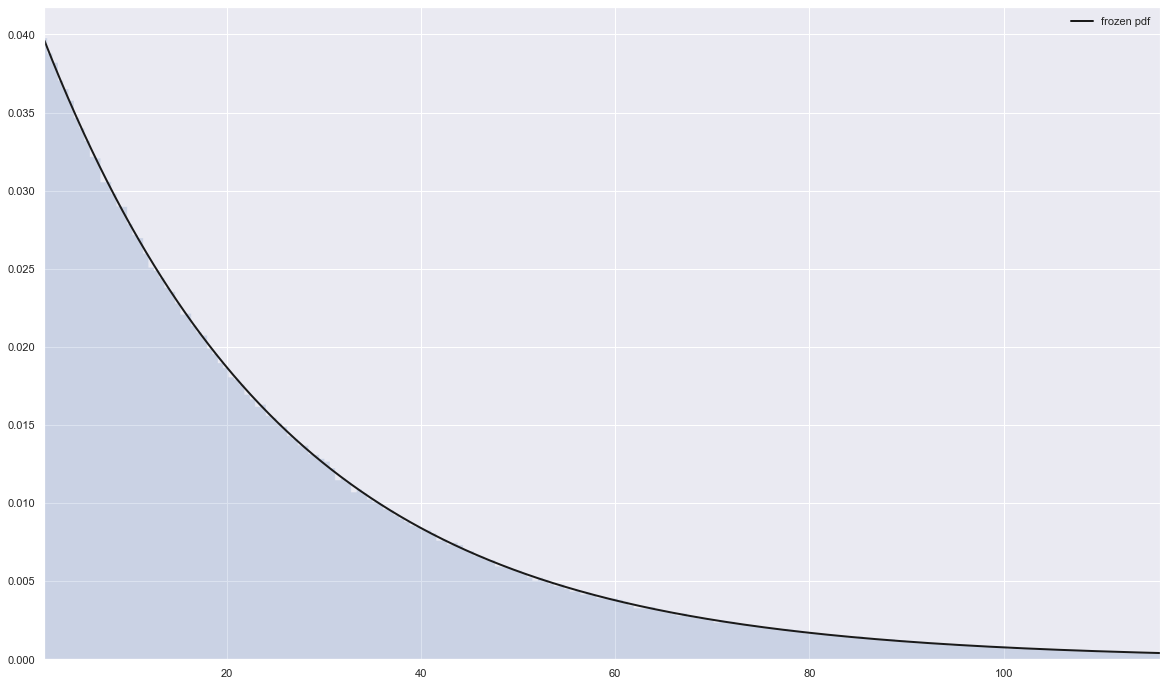

In [182]:
from scipy.stats import expon

expon_scale = 25
expon_shape = 1

expon_rvs = expon.rvs(expon_shape, scale=expon_scale, size=1000000)  # generate 100000 points
fig, axes = plt.subplots(1, 1, figsize=(20, 12))
x = np.linspace(expon.ppf(0.01, expon_shape, scale=expon_scale), expon.ppf(0.99, expon_shape, scale=expon_scale), 1000)

axes.plot(x, expon.pdf(x, expon_shape, scale=expon_scale), 'k-', lw=2, label='frozen pdf')
axes.hist(expon_rvs, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
axes.set_xlim([x[0], x[-1]])
axes.legend(loc='best', frameon=False)
plt.show()

In [183]:
sorted_expon_rvs = np.sort(expon_rvs)
expon_tail = list(sorted_expon_rvs[-10000:])[::-1]

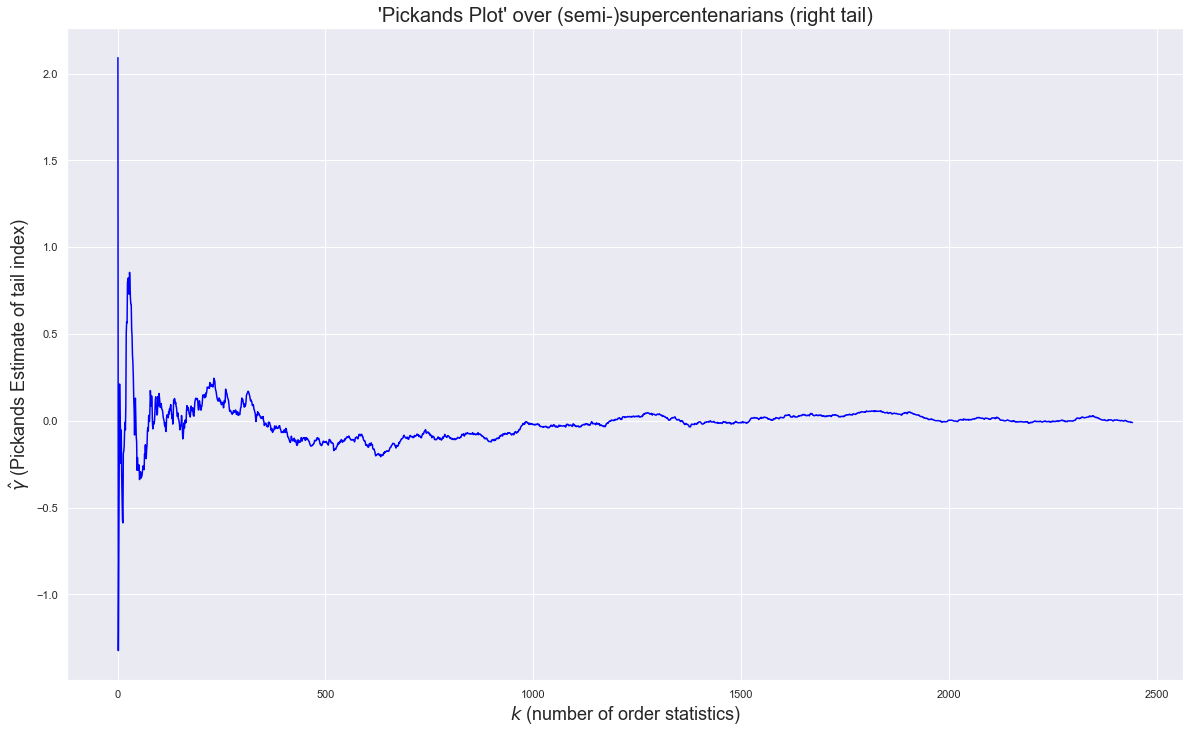

In [184]:
expon_estimates = []
k_max = math.floor(len(data) / 4)
for k in range(1, k_max):
    gamma, _ = Pickands_estimator(expon_tail, k)
    expon_estimates.append(gamma)
    
plt.figure(figsize=(20, 12))
plt.plot(np.arange(1, math.floor(len(data) / 4)), expon_estimates, 'blue')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\hat{\gamma}$ (Pickands Estimate of tail index)", fontsize=18)
plt.title("'Pickands Plot' over (semi-)supercentenarians (right tail)", fontsize=20)
plt.show()

## Hazard rate and auxiliary function estimation at u

As we know, the auxiliary function $a(u)$ is the reciprocal of hazard rate $h(u) = \frac{-S'(u)}{S(u)}$.

Calculate the empyrical hazard rate $\hat{h}(u)$ and use it to estimate the $S(u + x a(u))$.

In [231]:
# Step 1: Initialize an empty dictionary
aggregated_dict = {}

# Step 2: Loop through the list and update the dictionary with the counts
for item in data:
    if item in aggregated_dict:
        aggregated_dict[item] += 1
    else:
        aggregated_dict[item] = 1

# Step 3: Calculate the average count for those, who survived until 38000 days, use its ratio to len(data) as a proxy of hazard rate.
number_of_deaths_before_38500 = 0
no_items_le_38500 = 0
for item, count in aggregated_dict.items():
    if item < 38500:
        no_items_le_38500 += 1
        number_of_deaths_before_38500 += count

        
deaths_per_day = number_of_deaths_before_38500 / no_items_le_38500
print(f"deaths_per_day = {deaths_per_day}")
hazard_rate_at_u = deaths_per_day / len(data)
print(f"hazard_rate_at_u = {hazard_rate_at_u}")

deaths_per_day = 14.773333333333333
hazard_rate_at_u = 0.0015124215124215125


## How to express hazard rate through survival function

Let $x$ be the number of days person lives after the threshold $u=38350$.

Let $y$ be the total number of days a person lives:

$y = x + u$

Express Pickands-Balkema-de Haan formula through $y$:

$\frac{ S(u + a(u)(y - u)) }{ S(u) } = (1 + \gamma \frac{y - u}{\sigma})^{-1/\gamma}$

Let $z = u + a(u)(y - u)$ be the argument of survival function $S(u + a(u)(y - u))$ in Pickands-Balkema-de Haan formula:

$z = u + a(u) (y - u)$, $(y - u) = \frac{z - u}{a(u)}$

Express Pickands-Balkema-de Haan formula through $z$:

$S(z) = S(u) \cdot (1 + \gamma \frac{z - u}{\sigma \cdot a(u)})^{-1/\gamma}$

Express hazard rate through $z$:

$-S'(z) = \frac{-1}{ \gamma } \cdot S(u) \cdot (1 + \gamma \frac{z - u}{\sigma \cdot a(u)})^{-1/\gamma - 1} \cdot \frac{\gamma}{\sigma \cdot a(u)}$

$h(z) = \frac{-S'(z)}{S(z)} = \frac{\frac{1}{ \sigma \cdot a(u) } S(u) (1 + \gamma \frac{z - u}{\sigma \cdot a(u)})^{-1/\gamma - 1} }{ S(u) (1 + \gamma \frac{z - u}{\sigma \cdot a(u)})^{-1/\gamma} } = \frac{1}{ \sigma \cdot a(u) (1 + \gamma \frac{z - u}{a(u) \sigma} ) }$

Express hazard rate through number of days $y$ a person lives:

$h(y) = \frac{1}{ \sigma \cdot a(u) (1 + \gamma \frac{z - u}{a(u) \sigma} ) } = \frac{1}{ \sigma \cdot a(u) (1 + \gamma \frac{u + a(u) (y - u) - u}{a(u) \sigma} )} = \frac{1}{ \sigma \cdot a(u) (1 + \gamma \frac{y - u}{\sigma} ) }$

Calculate the hazard rate empyrically and find the day, when it approaches singularity:


Text(0.5, 1.0, 'Hazard rates in the late life')

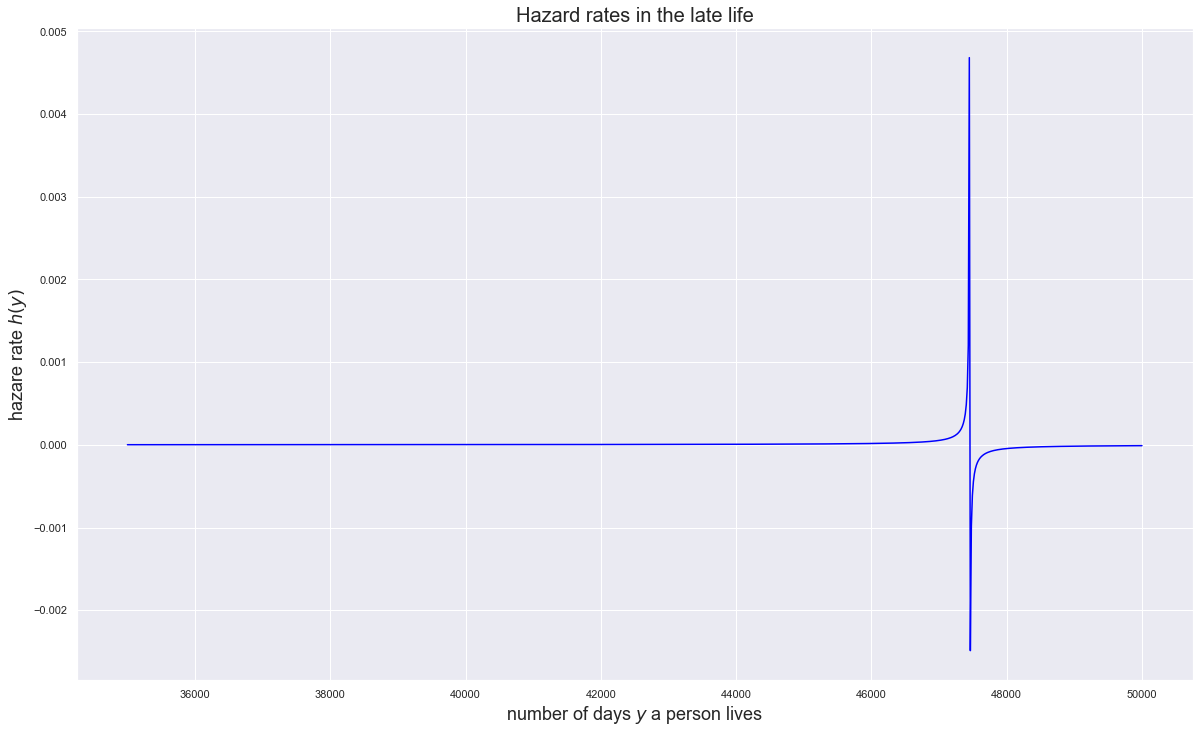

In [237]:
x = np.linspace(35000, 50000, 1000)

a = 661.38
hazard_rate = lambda y: 1 / (genpareto_scale * a * (1 + genpareto_shape * (y - genpareto_location) / (genpareto_scale) ))
hazard_rate_points = hazard_rate(x)
genpareto_shape, genpareto_scale, genpareto_location

plt.figure(figsize=(20, 12))
plt.plot(x, hazard_rate_points, 'blue')
plt.xlabel("number of days $y$ a person lives", fontsize=18)
plt.ylabel("hazare rate $h(y)$", fontsize=18)
plt.title("Hazard rates in the late life", fontsize=20)

In [238]:
h = hazard_rate(47452)  # singularity of hazard rate
w = 47452  # hard limit in days
h

0.03709753264006104

## Alternative approach to lifespan limit calculation

Given human lifespan and auxiliary function estimates, we can calculate the upper limit of human lifespan as:

$\hat{\omega} = X_{n-k} - \frac{\hat{a}(\frac{n}{k})}{\hat{\gamma}}$

IIRC this estimate has normally distributed confidence intervals as well.

# Discussion

I'd say these results confirm de Haan's claim that typical hazard rates per day in the late life are ~0.003.

They also confirm the existence of lifespan limit. However,  this limit is about 133 years, significantly higher than typical human lifespan, so there is not much differnece between $\gamma < 0$ and $\gamma = 0$ in practice.

# References:

* https://www.supercentenarians.org/en/publications/ - supercentenarians.org database publications
* https://www.hindawi.com/journals/ijmms/2021/9307475/ - how to handle censoring in survival analysis
* https://pure.uvt.nl/ws/portalfiles/portal/19635604/2017_051.pdf - de Haan et al. paper on existence of lifespan limit
* https://royalsocietypublishing.org/doi/pdf/10.1098/rsos.202097?pdf=reference - Rootzen et al. paper on non-existence of lifespan limit and (respectful) critique of de Haan's paper
* https://www.annualreviews.org/doi/full/10.1146/annurev-statistics-040120-025426 - another major publication by Rootzen et al. on this subject
* http://www.math.chalmers.se/~rootzen/ - list of recent publications of Rootzen (on human lifespan limit and not only)
* https://www.jstor.org/stable/2958083?seq=8 - Pickands estimator
* https://www.jstor.org/stable/2241666?seq=26 - derivation of Pickands estimator's confidence intervals and proof of asymptotic normality (see Theorem 2.3)
* https://search.r-project.org/CRAN/refmans/evmix/html/pickandsplot.html - documentation on R implementation of Pickands estimator with confidence intervals
* https://github.com/cran/evmix/blob/master/R/pickandsplot.r#L202 - code of R implementation of Pickands estimator
* https://cnrs.hal.science/hal-03479997v1/document - on contorversy surrounding the case of Jeanne Calment (by proponents of validity of her case)
* https://www.nature.com/articles/s43587-022-00291-z - discussion paper on existence of human lifespan limit